#### Importation des bibliothèques

In [1]:
import nilearn.datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

from nilearn.input_data import NiftiMasker, NiftiMapsMasker, NiftiSpheresMasker
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_connectome

#### Importation du jeu de données

In [2]:
dataset_abide = nilearn.datasets.fetch_abide_pcp(n_subjects=200)
pheno = pd.DataFrame(dataset_abide['phenotypic'])

In [3]:
#Fonction qui créé une liste contenant les individus asd et une liste contenant les individus td
def class_asd_td(pheno):
    asd = []
    td = []
    for i in range (len(pheno)):
        if pheno['DX_GROUP'].iloc[i] == 1 : 
            asd.append(i)
        else :
            td.append(i)
    return asd, td

In [4]:
asd, td = class_asd_td(pheno)

#### Affichage de matrices de corrélation sur les times series et de connectomes

In [5]:
# Atlas MSDL

data_dir = None
atlas_msdl_dataset = nilearn.datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_msdl_filepath = atlas_msdl_dataset.maps
labels_msdl = atlas_msdl_dataset.labels
atlas_msdl_coords = atlas_msdl_dataset.region_coords
n_regions_msdl = len(atlas_msdl_coords)

atlas_msdl_masker = NiftiMapsMasker(maps_img=atlas_msdl_filepath, standardize=True)

In [6]:
# Autres atlas

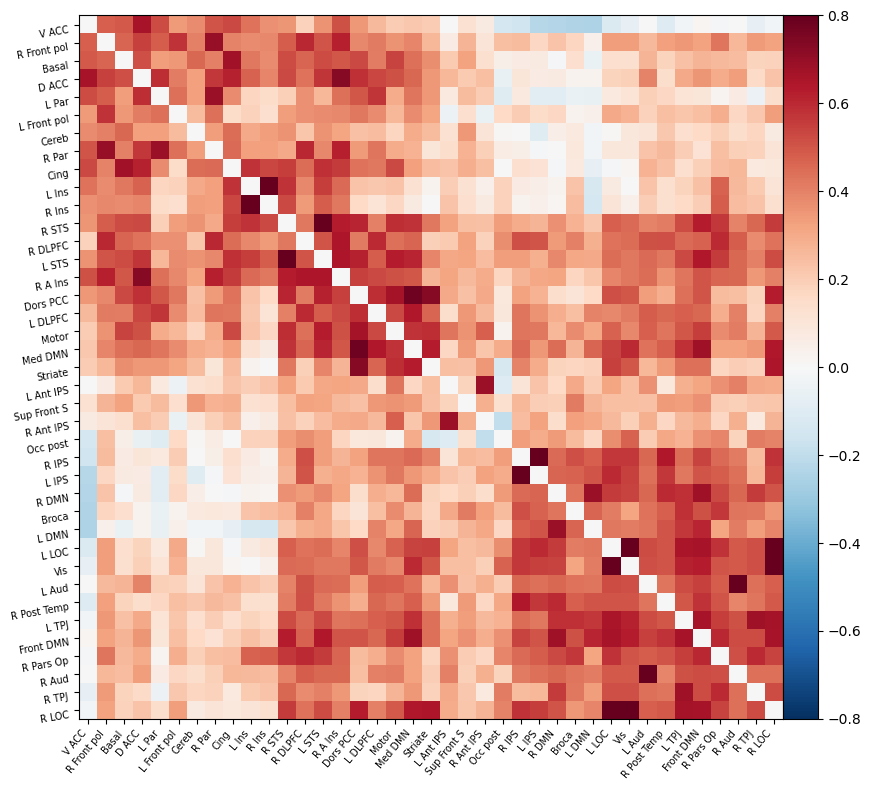

In [7]:
# Exemple d'affichage d'une matrice de corrélation

fmri_filepath_asd = dataset_abide['func_preproc'][0] #asd
data_in_atlas_msdl_asd = atlas_msdl_masker.fit_transform(fmri_filepath_asd)

#Création de la matrice de corrélation

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix_asd = correlation_measure.fit_transform([data_in_atlas_msdl_asd])[0]

# Affichage de la matrice de corrélation

np.fill_diagonal(correlation_matrix_asd, 0)
plotting.plot_matrix(correlation_matrix_asd, figure=(10, 8), labels=labels_msdl,
                     vmax=0.8, vmin=-0.8, reorder=True)

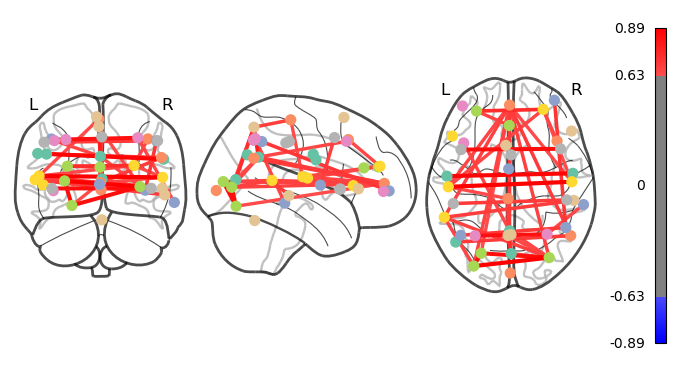

In [5]:
# Affichage du connectome

coords = atlas_msdl_dataset.region_coords
plot_connectome(correlation_matrix_asd, coords,
                edge_threshold="95%", colorbar=True)

#### Matrice de corrélation moyenne et connectome moyen dans chacun des groupes

In [25]:
#Création du masque de l'atlas msdl

atlas_msdl_masker_bis = NiftiMapsMasker(
    atlas_msdl_filepath,
    resampling_target="data",
    t_r=2,
    detrend=True,
    low_pass=0.1,
    high_pass=0.01,
    memory="nilearn_cache",
    memory_level=1,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
).fit()

In [28]:
#Création de deux listes avec les time series des individus asd dans une et des individus td dans l'autre

asd_ts = []
td_ts = []
pooled_subjects = []
groups = []  # asd or td

for subj in range (30):

    group = pheno['DX_GROUP'][subj]
    fmri_filepath = dataset_abide['func_preproc'][subj]
    
    time_series = atlas_msdl_masker_bis.transform(fmri_filepath)
    pooled_subjects.append(time_series)
    
    if group == 1:
        asd_ts.append(time_series)
    else : 
        td_ts.append(time_series)

    print(subj)
    
    groups.append(group)

print(f"Data has {len(asd_ts)} asd subjects.")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Data has 21 asd subjects.


Correlations of asd subjects are stacked in an array of shape (21, 39, 39)
Mean correlation has shape (39, 39).


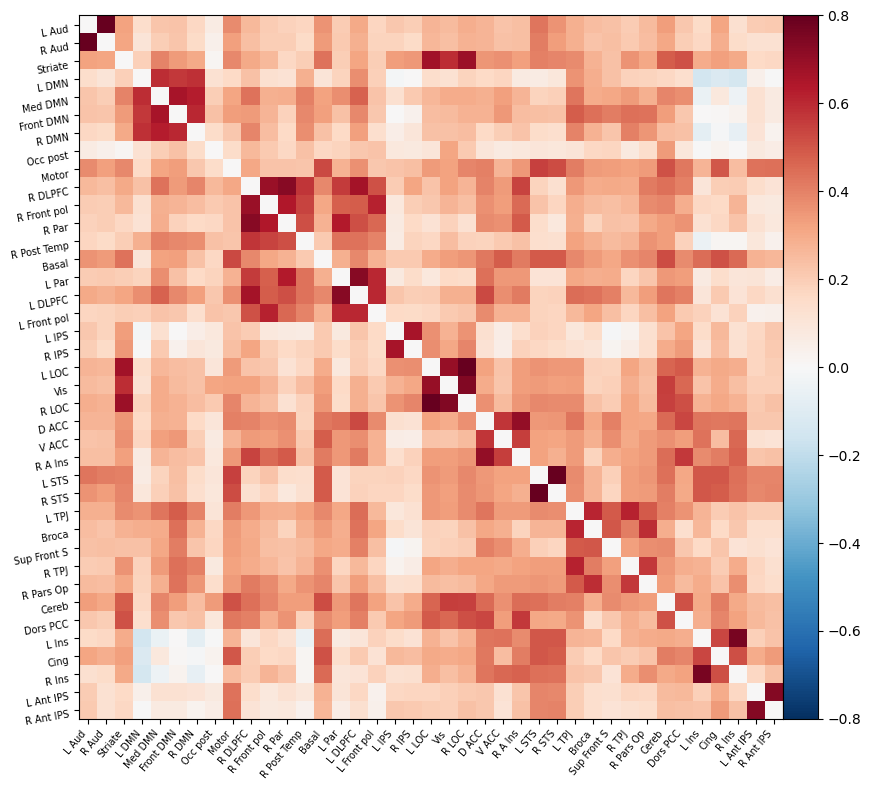

In [29]:
# Matrice de corrélation moyennée pour l'ensemble des sujets ASD

correlation_measure_asd = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)

correlation_matrices_asd = correlation_measure_asd.fit_transform(asd_ts)

# All individual coefficients are stacked in a unique 2D matrix.
print(
    "Correlations of asd subjects are stacked "
    f"in an array of shape {correlation_matrices_asd.shape}"
)

mean_correlation_matrix_asd = correlation_measure_asd.mean_
print(f"Mean correlation has shape {mean_correlation_matrix_asd.shape}.")

np.fill_diagonal(mean_correlation_matrix_asd, 0)
plotting.plot_matrix(mean_correlation_matrix_asd, figure=(10, 8), labels=labels_msdl,
                     vmax=0.8, vmin=-0.8, reorder=False)

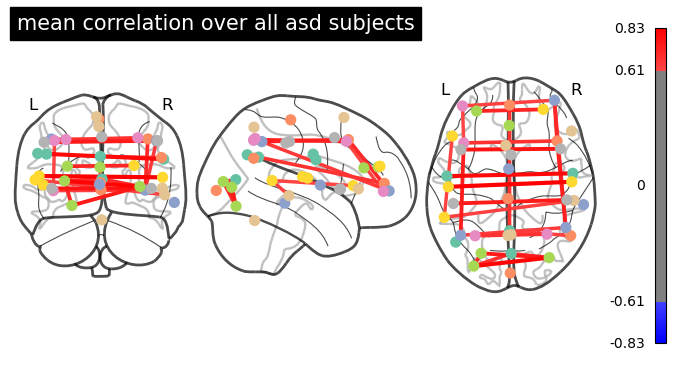

In [34]:
# Connectome moyenné pour l'ensemble des sujets ASD

plotting.plot_connectome(
    mean_correlation_matrix_asd,
    atlas_msdl_coords,
    title="mean correlation over all asd subjects",
    edge_threshold = "97%",
    colorbar = True,
)

Correlations of td subjects are stacked in an array of shape (9, 39, 39)
Mean correlation has shape (39, 39).


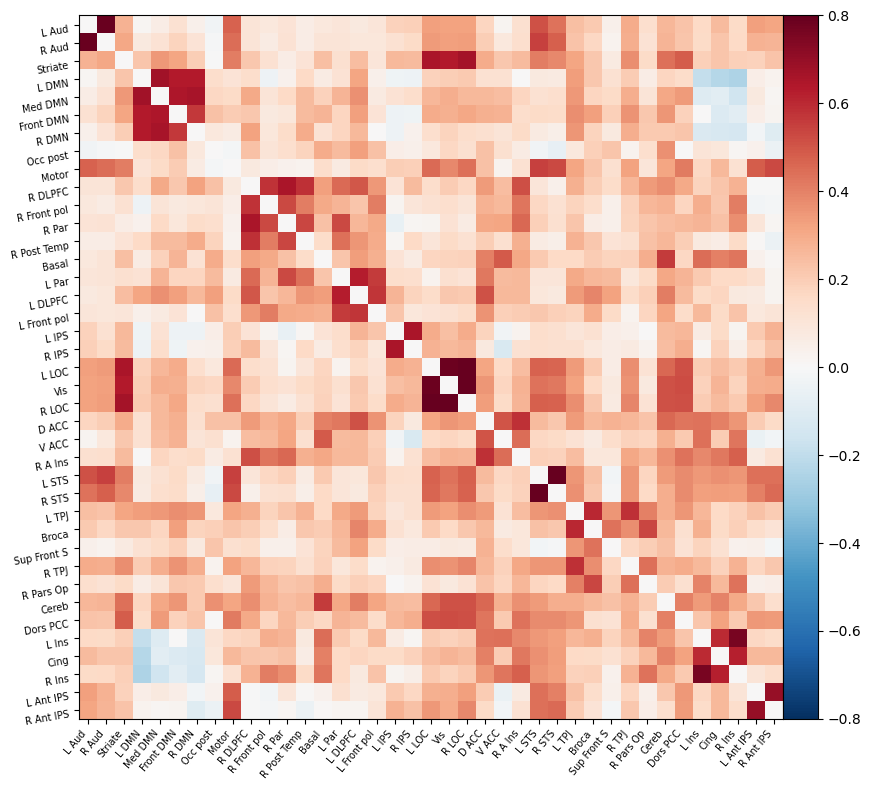

In [36]:
# Matrice de corrélation moyennée pour l'ensemble des sujets TD

correlation_measure_td = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)

correlation_matrices_td = correlation_measure_td.fit_transform(td_ts)

# All individual coefficients are stacked in a unique 2D matrix.
print(
    "Correlations of td subjects are stacked "
    f"in an array of shape {correlation_matrices_td.shape}"
)

mean_correlation_matrix_td = correlation_measure_td.mean_
print(f"Mean correlation has shape {mean_correlation_matrix_td.shape}.")

np.fill_diagonal(mean_correlation_matrix_td, 0)
plotting.plot_matrix(mean_correlation_matrix_td, figure=(10, 8), labels=labels_msdl,
                     vmax=0.8, vmin=-0.8, reorder=False)

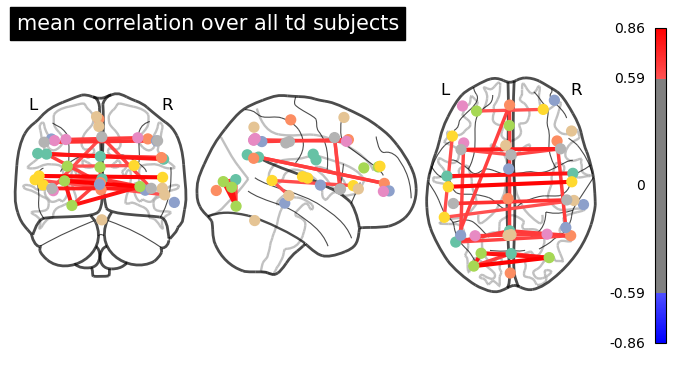

In [37]:
# Connectome moyenné pour l'ensemble des sujets TD

plotting.plot_connectome(
    mean_correlation_matrix_td,
    atlas_msdl_coords,
    title="mean correlation over all td subjects",
    edge_threshold= "97%",
    colorbar= True
)

#### Calcul du gFCD (global Functionnal Connectivity Density)

In [6]:
# Calcul gFCD (global Functionnal Connectivity Density)

def list_connectivity (correlation_matrix,threshold):
    len_matrix = correlation_matrix.shape[0]
    
    list_connectivity = [0 for k in range (len_matrix)]
    for i in range (len_matrix) :
        for j in range (i) :
            if correlation_matrix[i][j] > threshold : 
                list_connectivity[i] += 1
                list_connectivity[j] += 1
    return list_connectivity

In [7]:
correlation_measure = ConnectivityMeasure(kind='correlation')

def calcul_gfcd(n_subjects, masker, threshold) :

    list_sum_connectivity_asd = []
    list_sum_connectivity_td = []
    
    for i in range (n_subjects): 
        
        fmri_filepath = dataset_abide['func_preproc'][i]
        data_in_atlas = masker.fit_transform(fmri_filepath)
        correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]
        list_connect = list_connectivity (correlation_matrix, threshold)
        sum_connectivity = sum(list_connect)
        
        if pheno.iloc[i]['DX_GROUP'] == 1 : #asd
            list_sum_connectivity_asd.append(sum_connectivity)
        else : #td
            list_sum_connectivity_td.append(sum_connectivity)
        print(i)

    mean_asd = sum(list_sum_connectivity_asd)/len(list_sum_connectivity_asd)
    mean_td = sum(list_sum_connectivity_td)/len(list_sum_connectivity_td)
    print(list_sum_connectivity_asd)
    print("mean_asd :", mean_asd)
    print(list_sum_connectivity_td)
    print("mean_td :", mean_td)

    return list_sum_connectivity_asd, list_sum_connectivity_td, mean_asd, mean_td

In [18]:
# Exemple pour échantillon de 100 patients 
calcul_gfcd(100, atlas_msdl_masker,0.80)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[14, 0, 4, 4, 14, 10, 0, 2, 6, 8, 0, 2, 2, 2, 4, 24, 0, 4, 20, 4, 8, 22, 12, 0, 4, 4, 6, 0, 0, 0, 6, 0, 0, 2, 0, 0, 2, 2, 2, 0, 4, 2, 0, 0, 0, 2, 0, 0, 6, 0]
mean_asd : 4.16
[2, 8, 6, 10, 4, 6, 0, 2, 2, 26, 4, 4, 6, 2, 8, 8, 16, 6, 6, 8, 4, 6, 6, 10, 14, 0, 0, 10, 0, 0, 0, 2, 12, 0, 4, 2, 4, 8, 8, 6, 0, 4, 2, 0, 2, 8, 0, 0, 8, 0]
mean_td : 5.08


([14,
  0,
  4,
  4,
  14,
  10,
  0,
  2,
  6,
  8,
  0,
  2,
  2,
  2,
  4,
  24,
  0,
  4,
  20,
  4,
  8,
  22,
  12,
  0,
  4,
  4,
  6,
  0,
  0,
  0,
  6,
  0,
  0,
  2,
  0,
  0,
  2,
  2,
  2,
  0,
  4,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  6,
  0],
 [2,
  8,
  6,
  10,
  4,
  6,
  0,
  2,
  2,
  26,
  4,
  4,
  6,
  2,
  8,
  8,
  16,
  6,
  6,
  8,
  4,
  6,
  6,
  10,
  14,
  0,
  0,
  10,
  0,
  0,
  0,
  2,
  12,
  0,
  4,
  2,
  4,
  8,
  8,
  6,
  0,
  4,
  2,
  0,
  2,
  8,
  0,
  0,
  8,
  0],
 4.16,
 5.08)

#### Seed to voxel correlation

In [13]:
#Renvoie matrice de corrélation d'un seed avec les autres voxels

def seed_to_voxel_corr(subj, brain_masker, seed_masker):
    
    #fichier
    fmri_filepath = dataset_abide['func_preproc'][subj]
    #seed masker
    #seed_masker = NiftiSpheresMasker(psts_coords,radius=10,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
    seed_time_series = seed_masker.fit_transform(fmri_filepath)
    #brain masker
    #brain_masker = NiftiMasker(smoothing_fwhm=6,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
    brain_time_series = brain_masker.fit_transform(fmri_filepath)
    #matrice de correlation
    seed_to_voxel_correlations = np.dot(brain_time_series.T, seed_time_series) / seed_time_series.shape[0]
    print(seed_to_voxel_correlations.shape)

    return seed_to_voxel_correlations

In [14]:
#Moyenner différentes images NIFTI

def moyenne_images(list_images):
    
    a,b,c,d = list_images[0].get_fdata().shape
    nb_images = len(list_images)

    mean_mat = np.zeros((a,b,c,d))

    for i in range (a):
        for j in range (b):
            for k in range (c) :
                for l in range (d):
                    coeff = 0
                    for im in list_images : 
                        coeff += im.get_fdata()[i][j][k][l]
                    mean_mat [i][j][k][l] = coeff / nb_images
                    
    return nib.Nifti1Image(mean_mat, affine = list_images[0].affine)

In [41]:
psts_coords = [(47, -60, 4)]

(67431, 1)
0
(69757, 1)
1
(71399, 1)
2
(74408, 1)
3
(66581, 1)
4
(68332, 1)
5
(70174, 1)
6
(64985, 1)
7
(71226, 1)
8
(72772, 1)
9
(71157, 1)
10
(71366, 1)
11
(66198, 1)
12
(69920, 1)
13
(67970, 1)
14
(71729, 1)
15
(67225, 1)
16
(69519, 1)
17
(69020, 1)
18
(72674, 1)
19
(72018, 1)
20
(70976, 1)
44
(73874, 1)
46
(74767, 1)
47
(74626, 1)
64
(69589, 1)
65
(74419, 1)
66
(75418, 1)
67
(75279, 1)
68
(73250, 1)
69
(71338, 1)
70
(75123, 1)
71
(77085, 1)
72
(73014, 1)
73
(72022, 1)
74
(74838, 1)
75
(71603, 1)
76
(76103, 1)
77
(76544, 1)
78
(74063, 1)
79
(78190, 1)
80
(80530, 1)
81
(82110, 1)
82
(80254, 1)
83
(78725, 1)
84
(75519, 1)
85
(80578, 1)
86
(77527, 1)
87
(81008, 1)
88
(73932, 1)
89
(74414, 1)
103
(75396, 1)
104
(68616, 1)
105
(77676, 1)
106
(74220, 1)
107
(73820, 1)
108
(72664, 1)
109
(70425, 1)
110
(76459, 1)
130
(71162, 1)
131
(70807, 1)
132
(68966, 1)
133
(68558, 1)
134
(73762, 1)
135
(73396, 1)
136
(74917, 1)
137
(77875, 1)
138
(71363, 1)
139
(77307, 1)
140
(75148, 1)
141
(73849, 1)

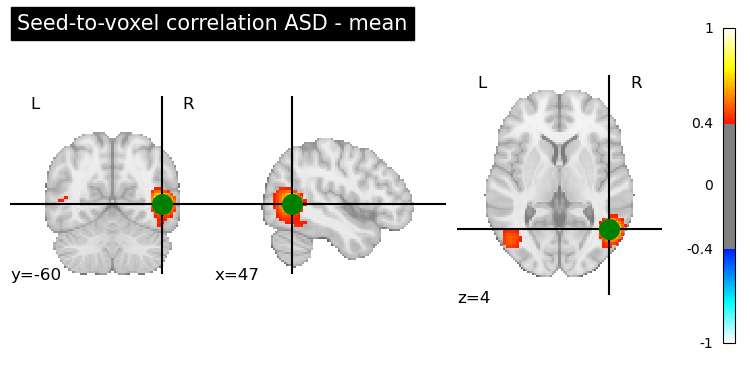

In [42]:
# Seed point correlation moyennée sur plusieurs sujets

liste_images_asd = []

seed_masker = NiftiSpheresMasker(psts_coords,radius=10,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
brain_masker = NiftiMasker(smoothing_fwhm=6,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)

for c in asd :
    
    seed_to_voxel_correlation = seed_to_voxel_corr(c, brain_masker, seed_masker)
    liste_images_asd.append(brain_masker.inverse_transform(seed_to_voxel_correlation.T))
    print(c)
    
# Compute mean correlation matrix for ASD group
seed_to_voxel_correlations_img_mean_asd = moyenne_images(liste_images_asd)

print("ASD") 

display = plotting.plot_stat_map(seed_to_voxel_correlations_img_mean_asd,threshold=0.4,vmax=1,cut_coords=psts_coords[0],title="Seed-to-voxel correlation ASD - mean")
display.add_markers(marker_coords=psts_coords, marker_color="g", marker_size=200)

C:\Users\elodi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\elodi\anaconda3\Lib\site-packages\nilearn\plotting\html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



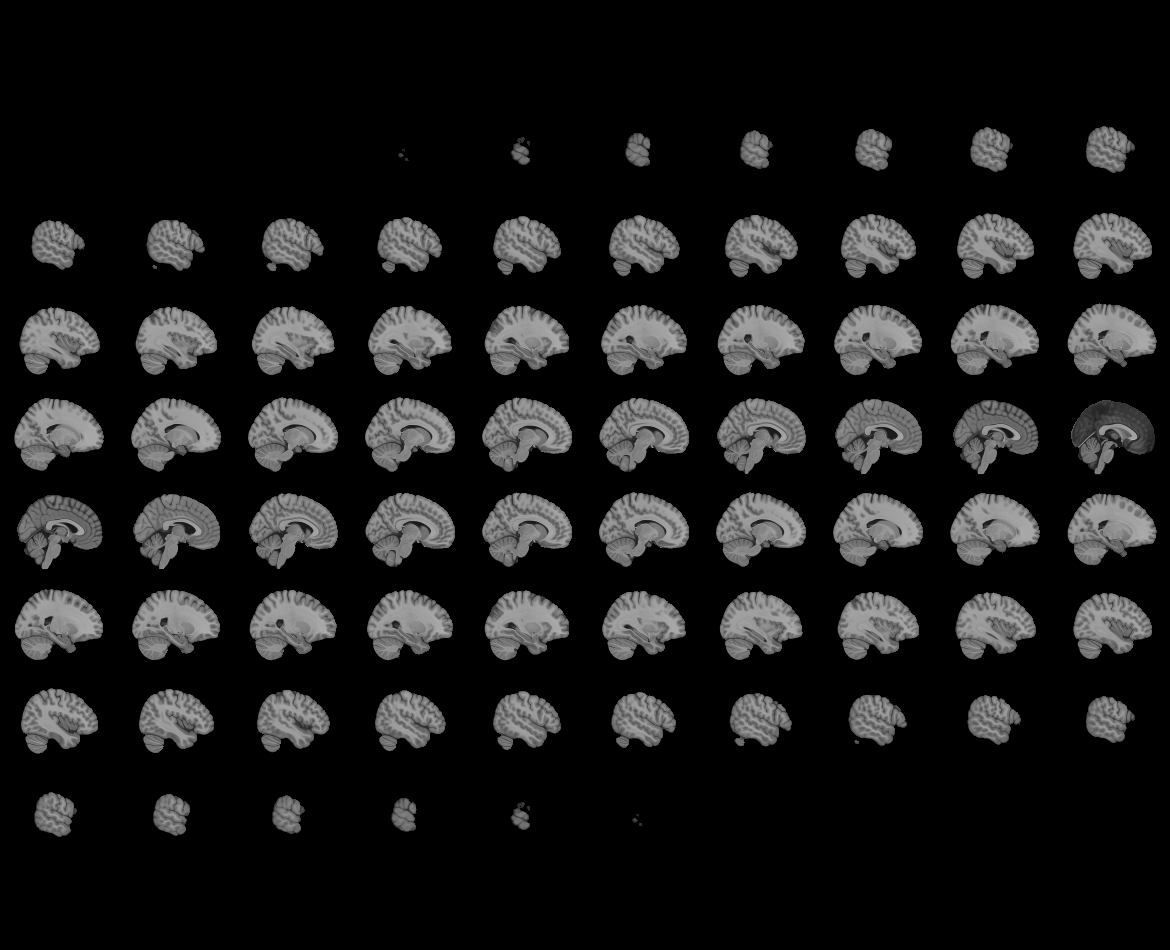
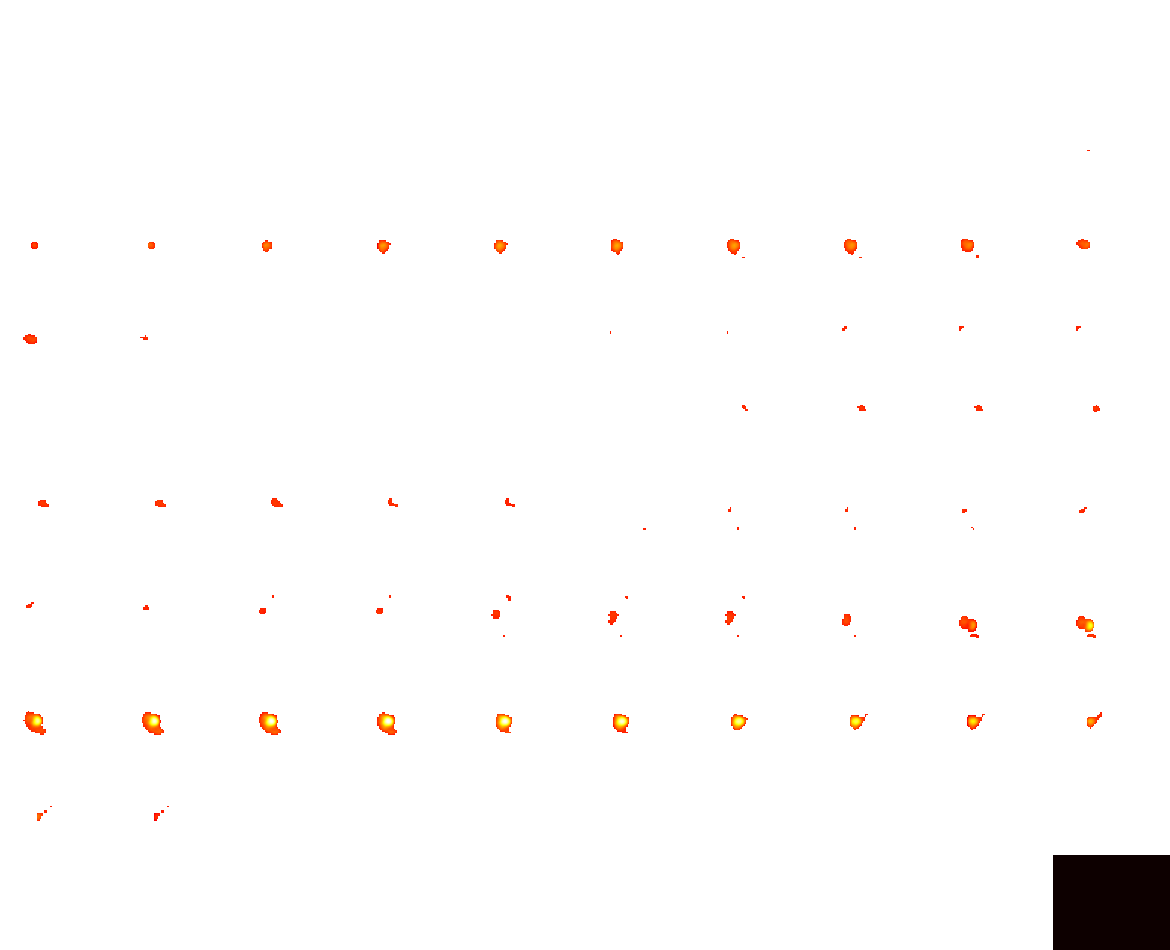

In [55]:
#Visualisation en 3D

plotting.view_img(seed_to_voxel_correlations_img_mean_asd, threshold=0.35,
                              cut_coords=[47, -60, 4],
                              title="ASD Group")

(70740, 1)
21
(76388, 1)
22
(65694, 1)
23
(74346, 1)
24
(70108, 1)
25
(64723, 1)
26
(72715, 1)
27
(67898, 1)
28
(69967, 1)
29
(68122, 1)
30
(69486, 1)
31
(66442, 1)
32
(68321, 1)
33
(71311, 1)
34
(68867, 1)
35
(61666, 1)
36
(69634, 1)
37
(66499, 1)
38
(70598, 1)
39
(71330, 1)
40
(66385, 1)
41
(73534, 1)
42
(65970, 1)
43
(77471, 1)
45
(70784, 1)
48
(68156, 1)
49
(75448, 1)
50
(75079, 1)
51
(77189, 1)
52
(73507, 1)
53
(79217, 1)
54
(70130, 1)
55
(72799, 1)
56
(79604, 1)
57
(74197, 1)
58
(76223, 1)
59
(75595, 1)
60
(73736, 1)
61
(76827, 1)
62
(72972, 1)
63
(78323, 1)
90
(78458, 1)
91
(78467, 1)
92
(78154, 1)
93
(77788, 1)
94
(76153, 1)
95
(77741, 1)
96
(80662, 1)
97
(80163, 1)
98
(79427, 1)
99
(78828, 1)
100
(77968, 1)
101
(79439, 1)
102
(73764, 1)
111
(75926, 1)
112
(77065, 1)
113
(76960, 1)
114
(72130, 1)
115
(71930, 1)
116
(73880, 1)
117
(76626, 1)
118
(75326, 1)
119
(73204, 1)
120
(74456, 1)
121
(71379, 1)
122
(76435, 1)
123
(70666, 1)
124
(69482, 1)
125
(78574, 1)
126
(75035, 1)
127


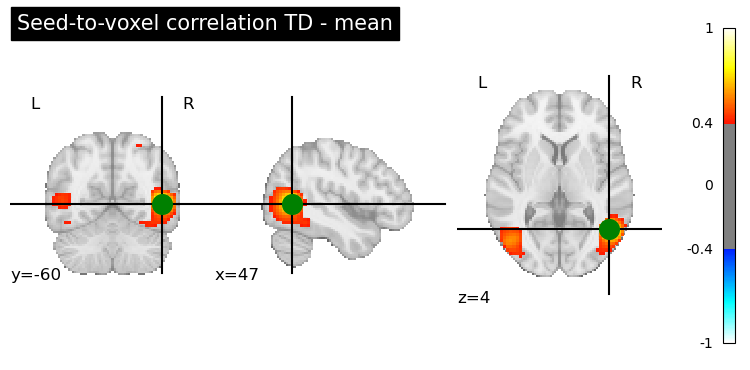

In [44]:
# Seed point correlation moyennée sur plusieurs sujets td

liste_images_td = []

seed_masker = NiftiSpheresMasker(psts_coords,radius=10,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)
brain_masker = NiftiMasker(smoothing_fwhm=6,detrend=True,standardize="zscore_sample",low_pass=0.1,high_pass=0.01,t_r=2,memory="nilearn_cache",memory_level=1,verbose=0)

for c in td :

    seed_to_voxel_correlation = seed_to_voxel_corr(c, brain_masker, seed_masker)
    liste_images_td.append(brain_masker.inverse_transform(seed_to_voxel_correlation.T))
    print(c)

seed_to_voxel_correlations_img_mean_td = moyenne_images(liste_images_td)

print("TD") 

display = plotting.plot_stat_map(seed_to_voxel_correlations_img_mean_td,threshold=0.4,vmax=1,cut_coords=psts_coords[0],title="Seed-to-voxel correlation TD - mean")
display.add_markers(marker_coords=psts_coords, marker_color="g", marker_size=200)

C:\Users\elodi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\elodi\anaconda3\Lib\site-packages\nilearn\plotting\html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



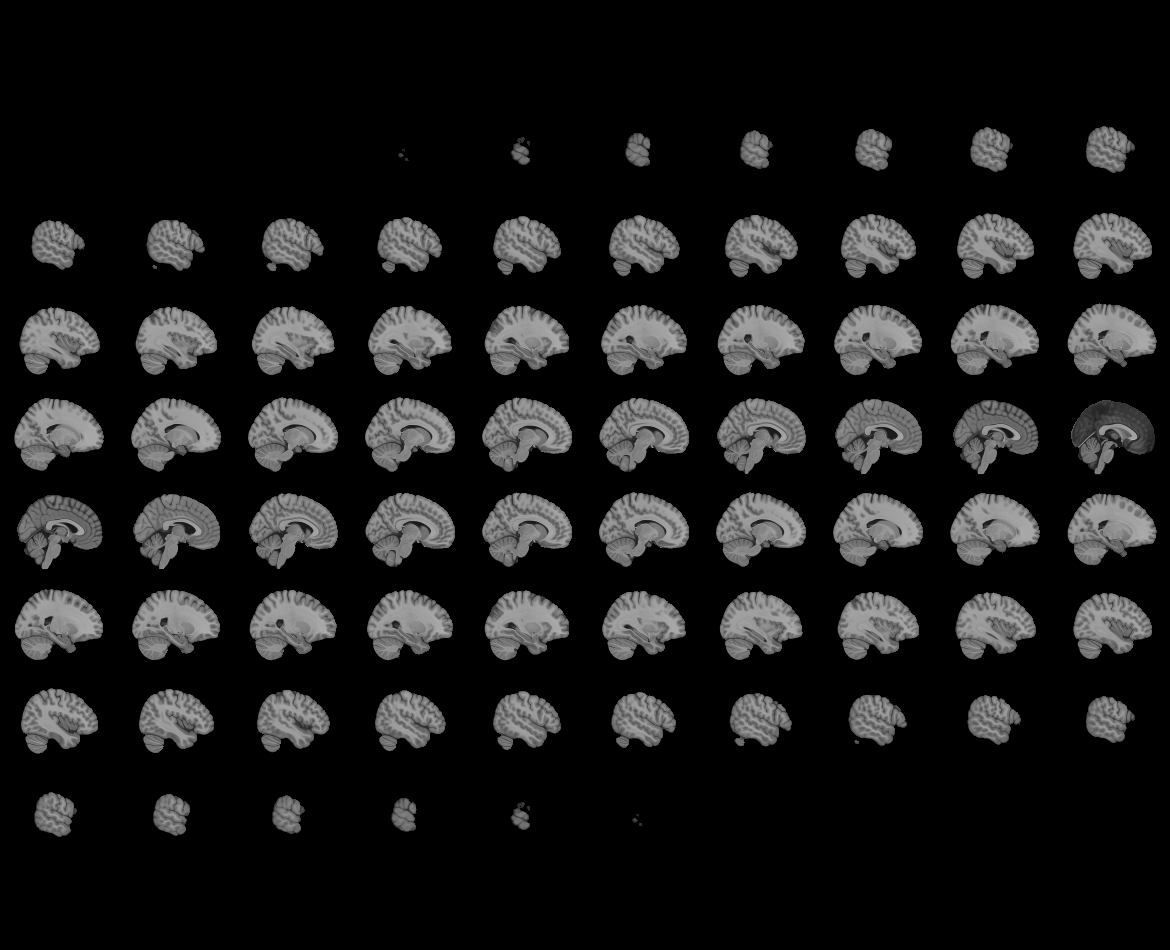
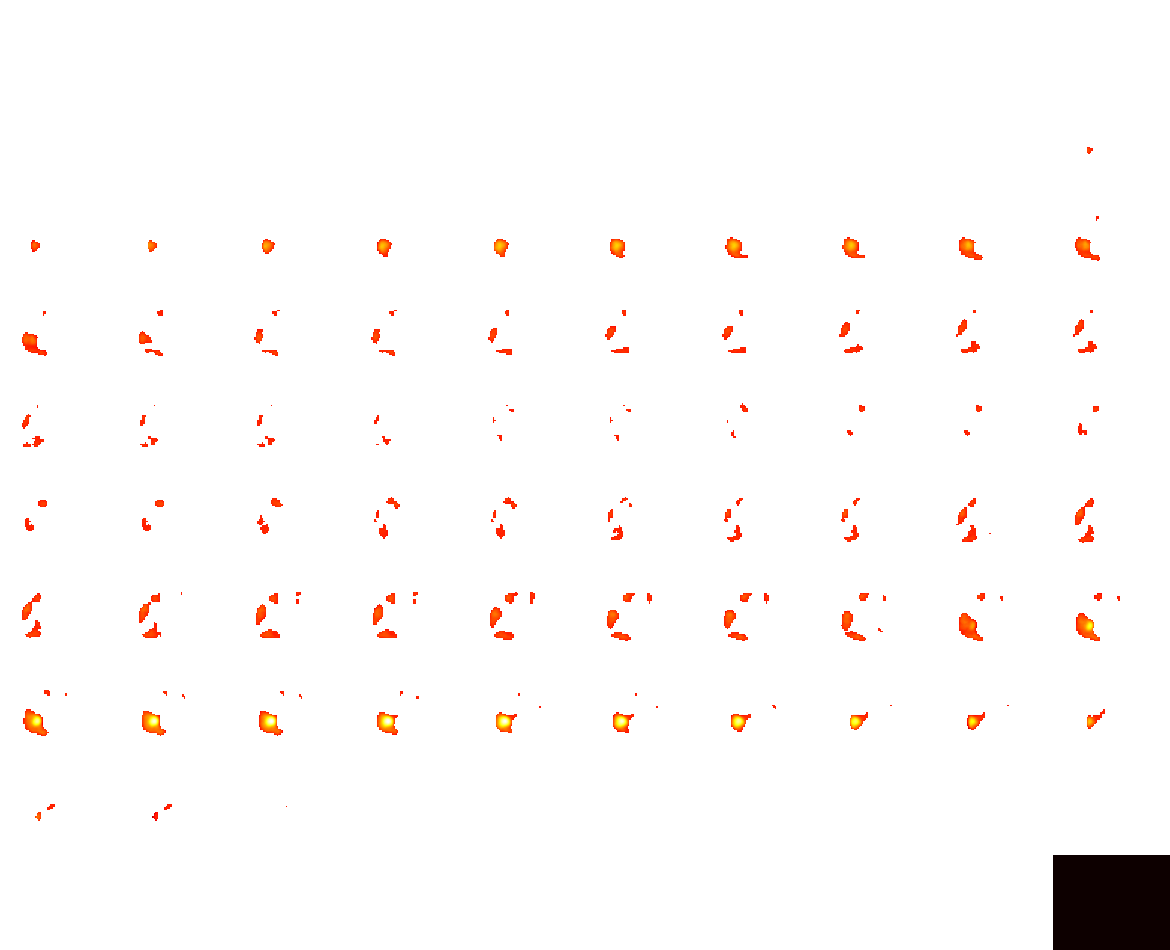

In [54]:
#Visualisation en 3D 

plotting.view_img(seed_to_voxel_correlations_img_mean_td, threshold=0.35,
                              cut_coords=[47, -60, 4],
                              title="TD Group")

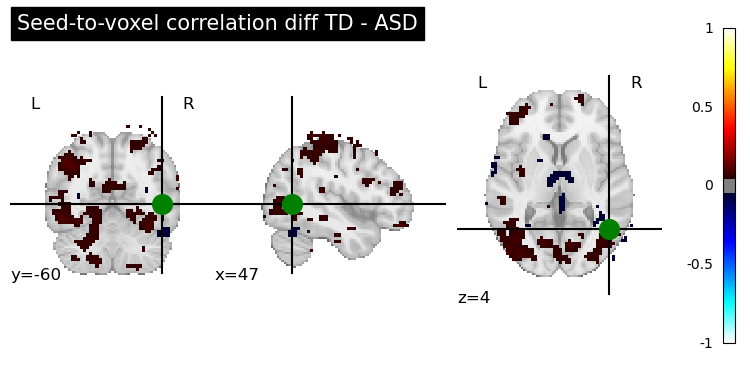

In [51]:
#Différence entre les deux images seed point correlation TD - ASD, visualisation 2D

affine_im = seed_to_voxel_correlations_img_mean_td.affine
mat_diff = seed_to_voxel_correlations_img_mean_td.get_fdata() - seed_to_voxel_correlations_img_mean_asd.get_fdata()
image_diff = nib.Nifti1Image(mat_diff, affine = affine_im)

display = plotting.plot_stat_map(image_diff, threshold = 0.05, vmax=1,cut_coords=psts_coords[0],title="Seed-to-voxel correlation diff TD - ASD")
display.add_markers(marker_coords=psts_coords, marker_color="g", marker_size=200)

C:\Users\elodi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\elodi\anaconda3\Lib\site-packages\nilearn\plotting\html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



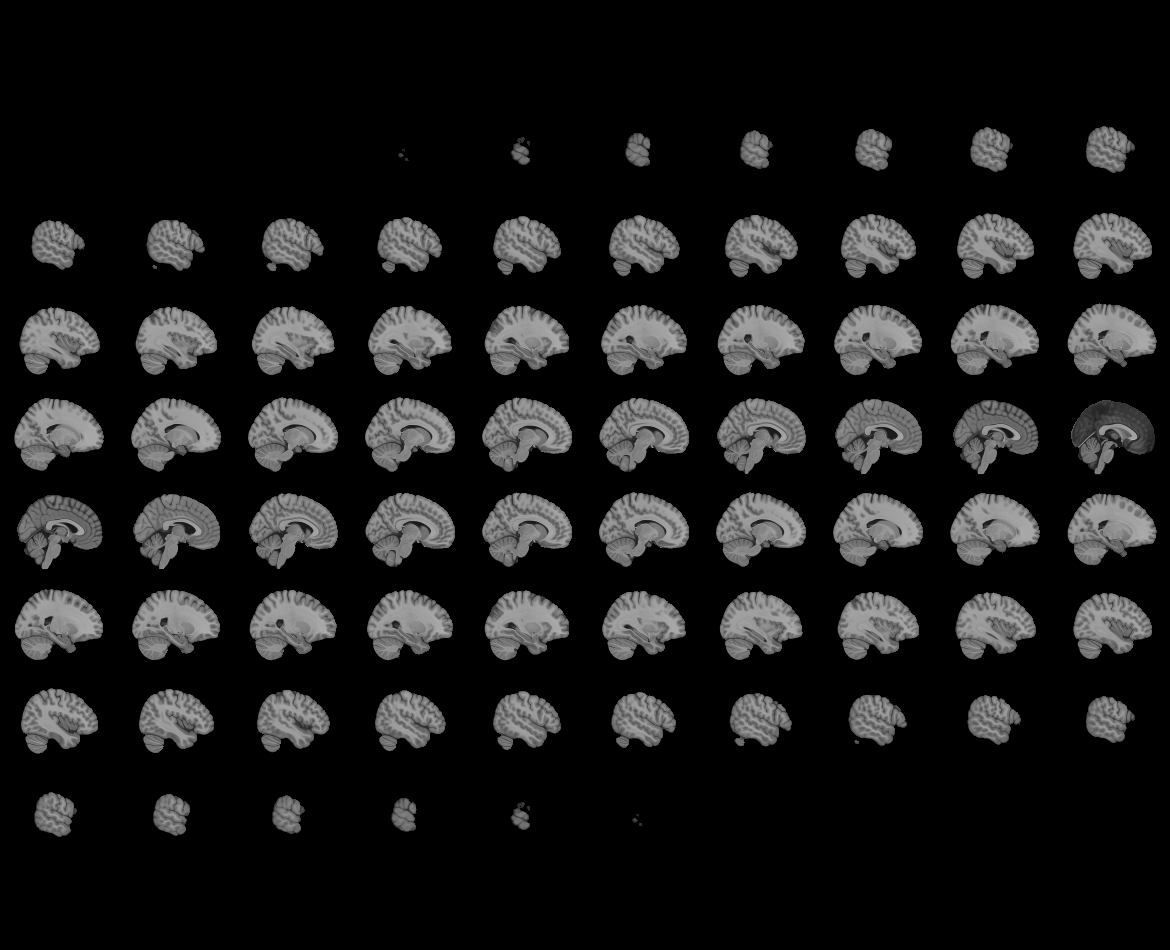
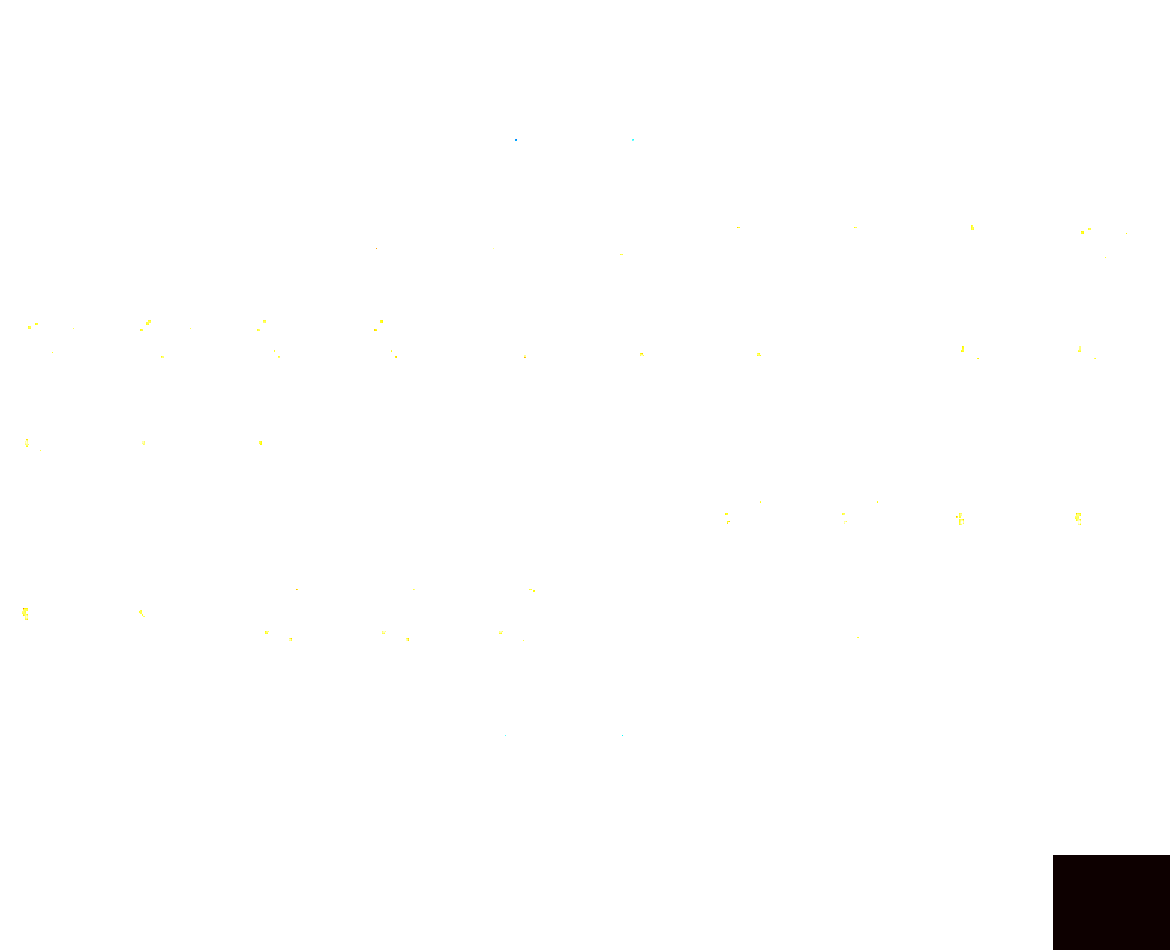

In [53]:
#Visualisation en 3D

plotting.view_img(image_diff, threshold=0.1,
                              cut_coords=[47, -60, 4],
                              title="Seed-to-voxel correlation diff TD - ASD")